In [1]:
from glob import glob
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
from shapely.geometry import box

# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

from constants import *
os.chdir(home_dir)

In [4]:
filepath = 'c:/users/marianne/NTSG_products/MOD17/MOD17A2_GPP.2004.M08.tif'
modis_pre = rxr.open_rasterio(filepath,
                              masked=True)

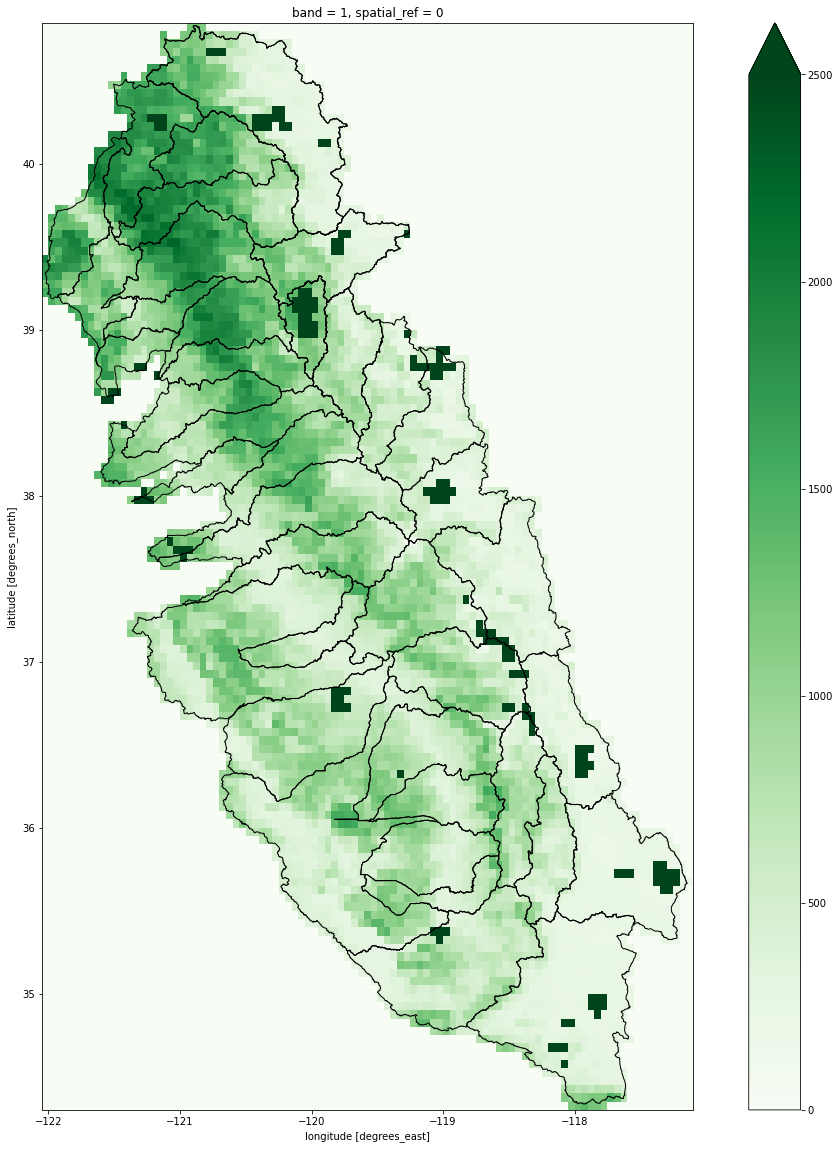

In [21]:
sn_trans = sn_watersheds.to_crs(modis_pre.rio.crs)
from rasterio.plot import plotting_extent

#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*sn_watersheds.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
modis_pre_clip = modis_pre.rio.clip(sn_trans.geometry,
                                                                    crs=sn_watersheds.crs,
                                                                    # Include all pixels even partial pixels
                                                                    all_touched=True,
                                                                    from_disk=True).squeeze()
# The final clipped data
#modis_pre_clip


modis_ext = plotting_extent(modis_pre_clip,
                            modis_pre_clip.rio.transform())

                            # View cropped data
f, ax = plt.subplots(figsize=(20,20))
modis_pre_clip.plot(ax=ax,cmap = 'Greens',vmin = 0,vmax=2500)
sn_trans.boundary.plot(ax=ax, linewidth = 1,
                    color="black")
plt.show()




In [ ]:
modis_pre = np.zeros((16,13,1200,1200))
for y in range(2000,2001):
    for m in range(1,13):
        if(m<10):
            ms='M0'+str(m)
        else:
            ms = 'M'+str(m)
        yr = 'Y'+str(y)

        path = os.path.join('modis-gpp/data/NTSG_Products/MOD17/TrashCan/Monthly_MOD17A2',yr,ms) # ,'*h08v05*.hdf')
        os.listdir(path)
        filepath = os.path.join(path,os.listdir(path)[0])
        modis_pre[y-2000][m] = rxr.open_rasterio(filepath,masked=True)['Gpp_1km']


In [13]:
os.chdir('/users/marianne/documents/data/mod17a2')
filepath = 'MOD16A2.A2021001.h08v05.061.2021067191539.hdf'
mod = rxr.open_rasterio(filepath,masked=True)


In [44]:
import pandas as pd
mod_all = np.zeros((20,13,131,99))
mod_dir = 'c:/users/marianne/NTSG_Products/MOD17/'
files = os.listdir(mod_dir)
for f in files:
    fp = os.path.join(mod_dir,f)
    yr = f.split(".")[1]
    year = int(yr)-2000
    mo = f.split(".")[2].split("M")[1]
    month = int(mo)
    modis_pre = rxr.open_rasterio(fp,
                              masked=True)
    modis_clip = modis_pre.rio.clip(sn_trans.geometry,
                    all_touched=True,
                    from_disk=True)

    modis_clip.rio.to_raster('c:/users/marianne/documents/data/modis_clip_'+str(year)+'_'+str(month)+'.tif')
    ''''
    
    mod_all[year,month,:,:] = modis_clip


np.save('users/marianne/documents/pe_snow_fires/data/mod_clip_all.npy',mod_all)
'''
   

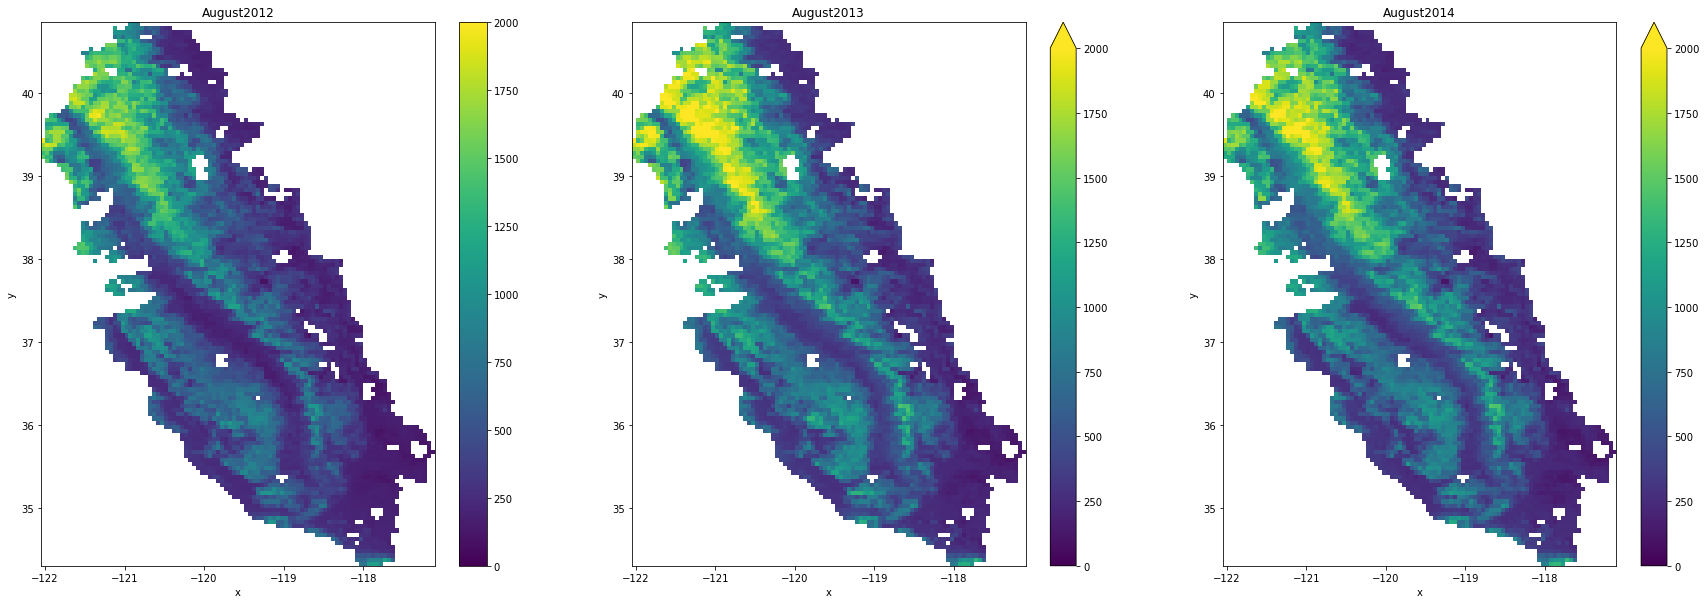

In [89]:
fig,ax=plt.subplots(1,3,figsize=(30,10))
axs = ax.flatten()
# Plotting Bounds Clip
month = 8
year = 12
maxval = np.nanmean(mod_all[year,month,:,:]) + 0.8*np.nanstd(mod_all[year,month,:,:])
for i in range(year,year+3):
    data = rxr.open_rasterio('c:/users/marianne/documents/data/modis_clip_'+str(i)+'_8.tif')[0,:,:]
    data = data.where(data<5000).where(data>0.1)
    data.plot(ax=axs[i-year],vmin=0,vmax=2000)
    axs[i-year].set_title('August '+str(i+2000))
    '''
    ep.plot_bands(
                ax=ax[i-year],
                extent=modis_ext,
                title='MODIS GPP: '+str(2000+i),
                cbar=True, 
                cmap = 'Greens',
                vmin=0, vmax=maxval)
'''

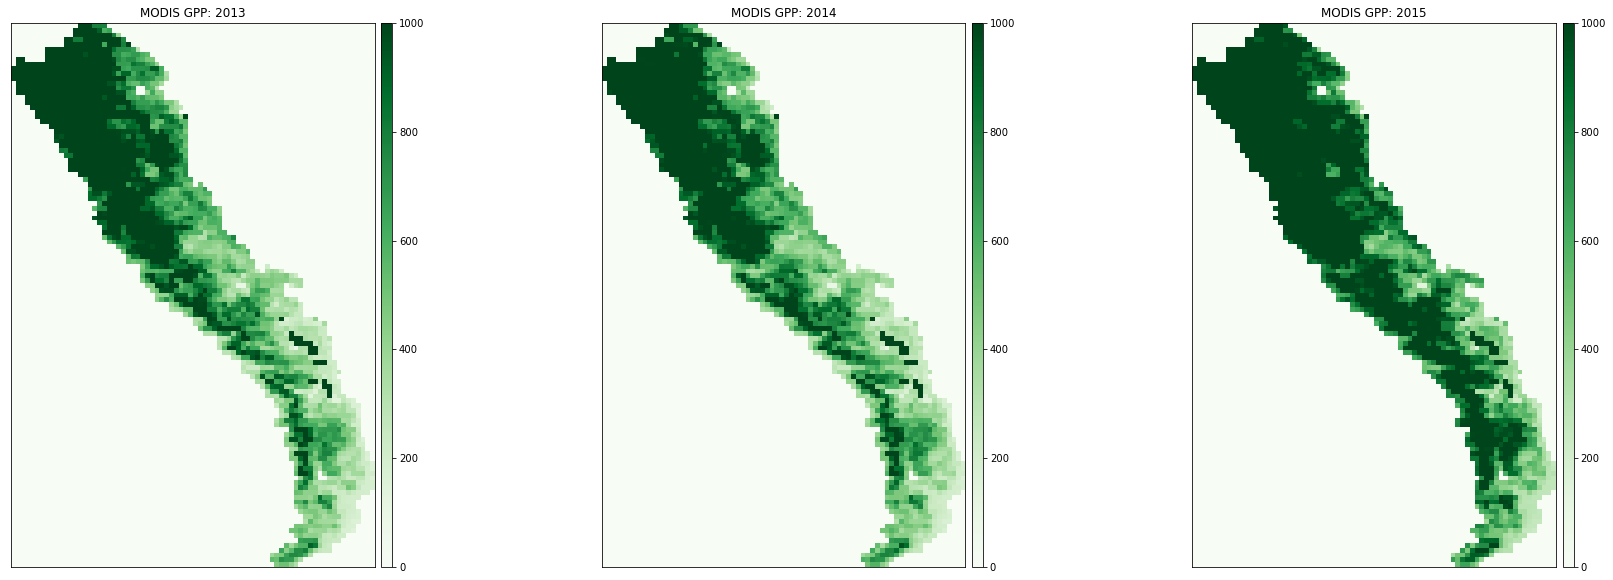

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(30,10))
for i in range(13,16):
    ep.plot_bands(mod_all[i,7,:,:],
                ax=ax[i-13],
                extent=modis_ext,
                title='MODIS GPP: '+str(2000+i),
                cbar=True, 
                cmap = 'Greens',
                vmin=0, vmax=1000)


In [7]:
#os.chdir('/users/marianne/documents/pe_snow_fires')
sn_watersheds= gpd.read_file('data/sn_watersheds.shp')
#os.chdir('/users/marianne/documents/data/')
mtbs= gpd.read_file('mtbs_perimeter_data/mtbs_perims_DD.shp')

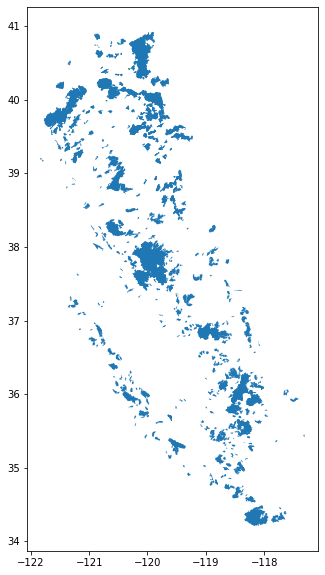

In [96]:
bounds = gpd.sjoin(mtbs,sn_watersheds)
fig,ax=plt.subplots(1,1,figsize=(30,10))
bounds.plot(ax=ax)
bounds.to_file('firebounds_sn.gdf')

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

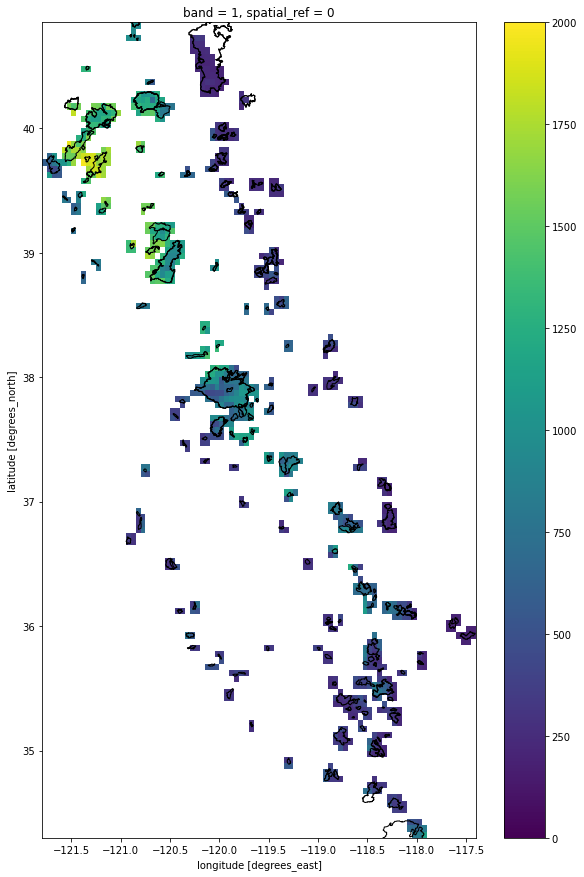

In [146]:
year = 2015
timestop =datetime.datetime(year,1,1)
timestart = datetime.datetime(year-10,1,1)
data = rxr.open_rasterio('c:/users/marianne/documents/data/modis_clip_'+str(year-2000)+'_8.tif')[0,:,:]
data = data.where(data<5000).where(data>0.1)
prev_fires = fire_sn[fire_sn['dt']<timestop]
prev_fires = prev_fires[prev_fires['dt']>timestart]
in_fire = data.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
#out_fire = data.rio.clip(-prev_fires.geometry, all_touched= True, from_disk = True)
fig,ax=plt.subplots(figsize=(10,15))
in_fire.plot(ax=ax,vmin=0,vmax=2000)
prev_fires.boundary.plot(ax=ax,color='k',linewidth = 1)

In [113]:
import datetime
tmp = []
for i in range(len(fire_sn)):
    tmp.append(datetime.datetime.strptime(fire_sn['Ig_Date'][i], '%Y-%m-%d'))
fire_sn['dt'] = tmp